In [ ]:
# Install required packages
!pip install sentencepiece datasets transformers

import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import random
import os
import urllib.request
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(1337)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Download Shakespeare data for additional training
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
def load_qa_datasets():
    try:
        print("Loading SQuAD dataset...")
        squad = load_dataset("squad_v2")
    except Exception as e:
        print(f"Error loading SQuAD dataset: {e}")
        squad = None

    try:
        print("Loading CoQA dataset...")
        coqa = load_dataset("coqa")
    except Exception as e:
        print(f"Error loading CoQA dataset: {e}")
        coqa = None

    return squad, coqa

# Load datasets
squad_dataset, coqa_dataset = load_qa_datasets()

# Preview examples
print("\nSQuAD Example:")
print(squad_dataset['train'][0])
print("\nCoQA Example:")
print(coqa_dataset['train'][0])

Loading SQuAD dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Loading CoQA dataset...


README.md:   0%|          | 0.00/8.17k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/793k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7199 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]


SQuAD Example:
{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

CoQA Example:
{'source': 'wikipedia', 'story': 'The Vatican Apostolic Library (), more common

In [ ]:
def create_expanded_dataset():
    """Create a larger, more diverse dataset for training"""
    # Create directory for additional texts
    os.makedirs('additional_texts', exist_ok=True)

    # List of public domain literary works to download
    literary_sources = [
        # Other classic literature
        {"url": "https://www.gutenberg.org/files/1513/1513-0.txt", "filename": "romeo_juliet.txt"},
        {"url": "https://www.gutenberg.org/files/1342/1342-0.txt", "filename": "pride_prejudice.txt"},
        {"url": "https://www.gutenberg.org/files/2701/2701-0.txt", "filename": "moby_dick.txt"},
        {"url": "https://www.gutenberg.org/files/84/84-0.txt", "filename": "frankenstein.txt"},
        {"url": "https://www.gutenberg.org/files/345/345-0.txt", "filename": "dracula.txt"},
        {"url": "https://www.gutenberg.org/files/1952/1952-0.txt", "filename": "three_musketeers.txt"},
        {"url": "https://www.gutenberg.org/files/98/98-0.txt", "filename": "tale_two_cities.txt"},
        {"url": "https://www.gutenberg.org/files/2641/2641-0.txt", "filename": "david_copperfield.txt"},
        {"url": "https://www.gutenberg.org/files/768/768-0.txt", "filename": "wuthering_heights.txt"},
        {"url": "https://www.gutenberg.org/files/1400/1400-0.txt", "filename": "great_expectations.txt"},
        {"url": "https://www.gutenberg.org/files/174/174-0.txt", "filename": "dorian_gray.txt"},
        {"url": "https://www.gutenberg.org/files/158/158-0.txt", "filename": "emma.txt"},
        {"url": "https://www.gutenberg.org/files/76/76-0.txt", "filename": "huckleberry_finn.txt"},
        {"url": "https://www.gutenberg.org/files/2701/2701-0.txt", "filename": "moby_dick.txt"},
        {"url": "https://www.gutenberg.org/files/120/120-0.txt", "filename": "treasure_island.txt"},
        {"url": "https://www.gutenberg.org/files/2600/2600-0.txt", "filename": "war_and_peace.txt"},
        {"url": "https://www.gutenberg.org/files/1260/1260-0.txt", "filename": "jane_eyre.txt"},
        {"url": "https://www.gutenberg.org/files/215/215-0.txt", "filename": "call_of_the_wild.txt"},
        {"url": "https://www.gutenberg.org/files/219/219-0.txt", "filename": "heart_of_darkness.txt"},
        {"url": "https://www.gutenberg.org/files/1661/1661-0.txt", "filename": "sherlock_holmes.txt"},
        {"url": "https://www.gutenberg.org/files/2814/2814-0.txt", "filename": "dubliners.txt"},
    ]

    # Download all texts
    for source in literary_sources:
        output_path = os.path.join('additional_texts', source["filename"])

        if not os.path.exists(output_path):
            try:
                print(f"Downloading {source['filename']}...")
                urllib.request.urlretrieve(source['url'], output_path)
                print(f"  Success: {source['filename']}")
            except Exception as e:
                print(f"  Failed to download {source['filename']}: {e}")

    # Create a combined text file
    all_text = ""

    # First add original Shakespeare text
    with open('input.txt', 'r', encoding='utf-8') as f:
        all_text += f.read() + "\n\n"

    # Add all downloaded texts
    for filename in os.listdir('additional_texts'):
        if filename.endswith('.txt'):
            try:
                with open(os.path.join('additional_texts', filename), 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()
                    all_text += text + "\n\n"
                    print(f"Added {filename} to combined text")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Save combined text
    with open('expanded_literature.txt', 'w', encoding='utf-8') as f:
        f.write(all_text)

    print(f"Created expanded_literature.txt with {len(all_text):,} characters")
    return 'expanded_literature.txt'

# Run the function to create the expanded dataset
expanded_file = create_expanded_dataset()

  Success: romeo_juliet.txt
  Success: pride_prejudice.txt
  Success: moby_dick.txt
  Success: frankenstein.txt
  Success: dracula.txt
  Success: three_musketeers.txt
  Success: tale_two_cities.txt
  Success: david_copperfield.txt
  Success: wuthering_heights.txt
  Success: great_expectations.txt
  Success: dorian_gray.txt
  Success: emma.txt
  Success: huckleberry_finn.txt
  Success: treasure_island.txt
  Success: war_and_peace.txt
  Success: jane_eyre.txt
  Success: call_of_the_wild.txt
  Success: heart_of_darkness.txt
  Success: sherlock_holmes.txt
  Success: dubliners.txt
Added romeo_juliet.txt to combined text
Added great_expectations.txt to combined text
Added treasure_island.txt to combined text
Added heart_of_darkness.txt to combined text
Added david_copperfield.txt to combined text
Added war_and_peace.txt to combined text
Added sherlock_holmes.txt to combined text
Added huckleberry_finn.txt to combined text
Added dubliners.txt to combined text
Added wuthering_heights.txt to co

In [ ]:
def format_coqa_as_conversations(coqa_dataset, num_samples=1000):
    """Convert CoQA dataset entries to conversation format"""
    print(f"Creating conversations from CoQA dataset...")
    conversations = []

    # First, let's inspect the structure of the first example to better understand it
    if len(coqa_dataset['train']) > 0:
        first_example = coqa_dataset['train'][0]
        print("CoQA dataset structure example:")
        for key in first_example:
            print(f"- {key}: {type(first_example[key])}")

    # Process sample entries
    for i, entry in enumerate(coqa_dataset['train']):
        if i >= num_samples:
            break

        if i % 200 == 0:
            print(f"Processing CoQA sample {i}/{min(num_samples, len(coqa_dataset['train']))}")

        # Extract story
        if 'story' in entry:
            story = entry['story']
        else:
            # Skip if no story is available
            continue

        # Create a conversation for each story
        conversation = ""

        # Check if the required fields are available
        if 'questions' not in entry or 'answers' not in entry:
            continue

        # Let's handle different possible structures
        questions = entry['questions']
        answers = entry['answers']

        # If questions and answers are dictionaries with indices
        if isinstance(questions, dict) and isinstance(answers, dict):
            # Get all question indices
            q_indices = sorted([idx for idx in questions.keys() if isinstance(idx, int) or idx.isdigit()])

            if len(q_indices) > 0:
                # First question with context
                first_idx = q_indices[0]
                q_text = questions[first_idx] if isinstance(questions[first_idx], str) else str(questions[first_idx])
                a_text = answers[first_idx] if first_idx in answers and isinstance(answers[first_idx], str) else "No answer provided"

                conversation += f"<USER>Given this context: '{story}', {q_text}</USER>"
                conversation += f"<ASSISTANT>{a_text}</ASSISTANT>\n"

                # Add subsequent questions
                for idx in q_indices[1:]:
                    q_text = questions[idx] if isinstance(questions[idx], str) else str(questions[idx])
                    a_text = answers[idx] if idx in answers and isinstance(answers[idx], str) else "No answer provided"
                    conversation += f"<USER>{q_text}</USER><ASSISTANT>{a_text}</ASSISTANT>\n"

        # If questions and answers are lists
        elif isinstance(questions, list) and isinstance(answers, list):
            if len(questions) > 0 and len(answers) > 0:
                # First question with context
                first_q = questions[0]
                first_a = answers[0]

                # Handle different ways the question/answer might be stored
                if isinstance(first_q, dict):
                    # Try common field names
                    if 'input_text' in first_q:
                        q_text = first_q['input_text']
                    elif 'text' in first_q:
                        q_text = first_q['text']
                    elif 'question' in first_q:
                        q_text = first_q['question']
                    else:
                        q_text = str(first_q)
                else:
                    q_text = str(first_q)

                if isinstance(first_a, dict):
                    # Try common field names
                    if 'input_text' in first_a:
                        a_text = first_a['input_text']
                    elif 'text' in first_a:
                        a_text = first_a['text']
                    elif 'answer' in first_a:
                        a_text = first_a['answer']
                    else:
                        a_text = str(first_a)
                else:
                    a_text = str(first_a)

                conversation += f"<USER>Given this context: '{story}', {q_text}</USER>"
                conversation += f"<ASSISTANT>{a_text}</ASSISTANT>\n"

                # Add subsequent questions
                for j in range(1, min(len(questions), len(answers))):
                    q = questions[j]
                    a = answers[j]

                    if isinstance(q, dict):
                        if 'input_text' in q:
                            q_text = q['input_text']
                        elif 'text' in q:
                            q_text = q['text']
                        elif 'question' in q:
                            q_text = q['question']
                        else:
                            q_text = str(q)
                    else:
                        q_text = str(q)

                    if isinstance(a, dict):
                        if 'input_text' in a:
                            a_text = a['input_text']
                        elif 'text' in a:
                            a_text = a['text']
                        elif 'answer' in a:
                            a_text = a['answer']
                        else:
                            a_text = str(a)
                    else:
                        a_text = str(a)

                    conversation += f"<USER>{q_text}</USER><ASSISTANT>{a_text}</ASSISTANT>\n"

        conversation += "\n"
        if conversation.strip():  # Only add non-empty conversations
            conversations.append(conversation)

    print(f"Created {len(conversations)} conversations from CoQA")
    return conversations

In [ ]:
def format_squad_as_conversations(squad_dataset, num_samples=1000):
    """Convert SQuAD dataset entries to conversation format"""
    print(f"Creating conversations from SQuAD dataset...")
    conversations = []

    # Process sample entries
    for i, entry in enumerate(squad_dataset['train']):
        if i >= num_samples:
            break

        if i % 200 == 0:
            print(f"Processing SQuAD sample {i}/{min(num_samples, len(squad_dataset['train']))}")

        # Extract context, question and answer
        context = entry['context']
        question = entry['question']

        # Handle unanswerable questions
        if entry.get('is_impossible', False):
            answer = "I don't have enough information to answer that question based on the given context."
        else:
            answers = entry['answers']
            answer = answers['text'][0] if answers['text'] else "No answer provided"

        # Create conversation with context included
        # Clean text
        context = context.replace('\n', ' ').strip()
        question = question.replace('\n', ' ').strip()
        answer = answer.replace('\n', ' ').strip()

        # Truncate long contexts
        if len(context) >  400:
            context = context[:397] + "..."

        conversation = f"<USER>Given this context: '{context}', {question}</USER><ASSISTANT>{answer}</ASSISTANT>\n\n"
        conversations.append(conversation)

    print(f"Created {len(conversations)} conversations from SQuAD")
    return conversations

def create_synthetic_qa_conversations(num_samples=1000):
    """Create synthetic QA conversations when the real dataset fails"""
    print(f"Creating {num_samples} synthetic QA conversations...")
    conversations = []

    # Simple contexts and questions
    contexts = [
        "The quick brown fox jumps over the lazy dog.",
        "In 1492, Columbus sailed the ocean blue.",
        "The early bird catches the worm.",
        "The Industrial Revolution began in Great Britain in the 18th century.",
        "Water is composed of hydrogen and oxygen atoms.",
        "The Declaration of Independence was signed in 1776.",
        "The human brain has approximately 86 billion neurons.",
        "The Great Wall of China is over 13,000 miles long.",
        "Shakespeare wrote approximately 37 plays and 154 sonnets.",
        "The first artificial satellite, Sputnik 1, was launched by the Soviet Union in 1957."
    ]

    questions = [
        "What does the fox do?",
        "When did Columbus sail?",
        "What does the early bird catch?",
        "Where did the Industrial Revolution begin?",
        "What elements compose water?",
        "When was the Declaration of Independence signed?",
        "How many neurons does the human brain have?",
        "How long is the Great Wall of China?",
        "How many plays did Shakespeare write?",
        "What was the first artificial satellite?"
    ]

    answers = [
        "The fox jumps over the lazy dog.",
        "Columbus sailed in 1492.",
        "The early bird catches the worm.",
        "The Industrial Revolution began in Great Britain.",
        "Water is composed of hydrogen and oxygen atoms.",
        "The Declaration of Independence was signed in 1776.",
        "The human brain has approximately 86 billion neurons.",
        "The Great Wall of China is over 13,000 miles long.",
        "Shakespeare wrote approximately 37 plays.",
        "The first artificial satellite was Sputnik 1, launched by the Soviet Union in 1957."
    ]

    # Generate conversations
    for i in range(num_samples):
        idx = i % len(contexts)
        context = contexts[idx]
        question = questions[idx]
        answer = answers[idx]

        conversation = f"<USER>Given this context: '{context}', {question}</USER><ASSISTANT>{answer}</ASSISTANT>\n\n"
        conversations.append(conversation)

    print(f"Created {len(conversations)} synthetic QA conversations")
    return conversations

def create_diverse_conversations(input_file, num_literary_conversations=1000):
    """Create diverse conversation data from a large text corpus"""
    print(f"Creating conversations from {input_file}...")

    try:
        # Read the file
        with open(input_file, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()

        # Split into decent-sized chunks (paragraphs or sentences)
        # This split handles various text formats - using simpler regex to avoid errors
        chunks = re.split(r'\n\n+|\n---+|\n\*\*\*+|CHAPTER', text)
        chunks = [chunk.strip() for chunk in chunks if len(chunk.strip()) > 50 and len(chunk.strip()) < 500]

        if not chunks:
            # If splitting didn't work, just take simple slices of the text
            chunks = [text[i:i+400].strip() for i in range(0, len(text), 400)]
            chunks = [chunk for chunk in chunks if len(chunk) > 50]

        random.shuffle(chunks)  # Shuffle to mix different sources

        print(f"Generated {len(chunks)} text chunks")
    except Exception as e:
        print(f"Error reading/processing file: {e}")
        # Create some dummy chunks if file reading fails
        chunks = [f"Literature sample text {i}" for i in range(1000)]

    # Create more specific literary prompts
    literary_prompts = [
        "What are the main themes in Shakespeare's Hamlet?",
        "Explain the character of Macbeth in Shakespeare's play.",
        "How does Jane Austen critique society in Pride and Prejudice?",
        "What gothic elements are present in Wuthering Heights?",
        "How does Dickens use symbolism in his novels?",
        "What makes a character memorable in literature?",
        "How does setting influence plot in classic novels?",
        "What is the importance of symbolism in literature?",
        "How do authors create suspense in their writing?"
    ]

    conversations = []

    # Create example high-quality conversations
    example_conversations = [
        "<USER>What are the main themes in Shakespeare's Hamlet?</USER><ASSISTANT>The main themes in Hamlet include revenge, madness, mortality, and corruption. Shakespeare explores how Hamlet's quest for vengeance consumes him, raising questions about the moral cost of revenge. The theme of madness is shown through Hamlet's feigned insanity and Ophelia's genuine descent into madness. Death and mortality are constantly present, from the ghost to the famous graveyard scene.</ASSISTANT>\n\n"
    ]

    # Add these high-quality example conversations first
    conversations.extend(example_conversations)

    # Generate additional conversations
    for i in range(min(num_literary_conversations, len(chunks))):
        if i % 200 == 0:
            print(f"Creating conversation {i}/{min(num_literary_conversations, len(chunks))}")

        prompt = random.choice(literary_prompts)
        response = chunks[i]

        # Clean the response
        response = response.replace('\n', ' ').strip()
        response = re.sub(r'\s+', ' ', response)

        # Truncate long responses
        if len(response) > 400:
            response = response[:397] + "..."

        # Create conversation format WITH EXPLICIT TAGS
        conversation = f"<USER>{prompt}</USER><ASSISTANT>{response}</ASSISTANT>\n\n"
        conversations.append(conversation)

    print(f"Created {len(conversations)} conversations from literary sources")
    return conversations

# Create conversation data
try:
    # Create SQuAD conversations
    try:
        squad_conversations = format_squad_as_conversations(squad_dataset, num_samples=1000)
    except Exception as e:
        print(f"Error processing SQuAD dataset: {e}")
        squad_conversations = create_synthetic_qa_conversations(500)

    # Create CoQA-style conversations
    try:
        # Since CoQA is causing issues, let's just create synthetic ones
        coqa_conversations = create_synthetic_qa_conversations(500)
    except Exception as e:
        print(f"Error creating synthetic CoQA conversations: {e}")
        coqa_conversations = []

    # Create literary conversations
    try:
        literary_conversations = create_diverse_conversations(expanded_file, num_literary_conversations=1000)
    except Exception as e:
        print(f"Error creating literary conversations: {e}")
        # Create simple literary conversations
        literary_conversations = []
        for i in range(1000):
            prompt = "Tell me about literature."
            response = f"Literature is a form of art that uses language to express ideas and emotions. Example {i}."
            literary_conversations.append(f"<USER>{prompt}</USER><ASSISTANT>{response}</ASSISTANT>\n\n")

    # Combine all conversations
    all_conversations = squad_conversations + coqa_conversations + literary_conversations
    print(f"Total number of conversations: {len(all_conversations)}")

    # Write to file with error handling
    try:
        with open('combined_conversations.txt', 'w', encoding='utf-8') as f:
            for conv in all_conversations:
                f.write(conv)
        print(f"Created combined_conversations.txt with {len(all_conversations)} conversations")
    except Exception as e:
        print(f"Error writing to file: {e}")

except Exception as e:
    print(f"Unexpected error: {e}")
    # Create a minimal dataset that will work
    basic_conversations = []
    for i in range(3000):
        basic_conversations.append(f"<USER>Question {i}?</USER><ASSISTANT>Answer {i}.</ASSISTANT>\n\n")

    with open('combined_conversations.txt', 'w', encoding='utf-8') as f:
        for conv in basic_conversations:
            f.write(conv)

    print(f"Created combined_conversations.txt with {len(basic_conversations)} basic conversations")

Creating conversations from SQuAD dataset...
Processing SQuAD sample 0/1000
Processing SQuAD sample 200/1000
Processing SQuAD sample 400/1000
Processing SQuAD sample 600/1000
Processing SQuAD sample 800/1000
Created 1000 conversations from SQuAD
Creating 500 synthetic QA conversations...
Created 500 synthetic QA conversations
Creating conversations from expanded_literature.txt...
Generated 36073 text chunks
Creating conversation 0/1000
Creating conversation 200/1000
Creating conversation 400/1000
Creating conversation 600/1000
Creating conversation 800/1000
Created 1001 conversations from literary sources
Total number of conversations: 2501
Created combined_conversations.txt with 2501 conversations


In [ ]:
# Create directory for tokenizer
!mkdir -p sp_model

def train_sentencepiece_tokenizer(input_file, model_prefix, vocab_size=8000):
    """Train a SentencePiece tokenizer on the conversation data"""
    spm_args = spm_args = [
        f'--input={input_file}',
        f'--model_prefix={model_prefix}',
        f'--vocab_size={vocab_size}',
        '--character_coverage=0.99999',
        '--model_type=bpe',  # Changed from unigram
        '--split_by_unicode_script=true',
        '--split_by_number=true',
        '--split_by_whitespace=true',
        '--normalization_rule_name=nfkc',
        '--add_dummy_prefix=false',
        '--remove_extra_whitespaces=false',
        '--hard_vocab_limit=false',
        '--max_sentence_length=8192',
        '--pad_id=0',
        '--unk_id=1',
        '--bos_id=2',
        '--eos_id=3',
        '--user_defined_symbols=<USER>,</USER>,<ASSISTANT>,</ASSISTANT>',
        '--control_symbols=<STOP>'
    ]
    spm.SentencePieceTrainer.train(' '.join(spm_args))

    # Verify special tokens
    sp = spm.SentencePieceProcessor()
    sp.load(f'{model_prefix}.model')
    print("\nSpecial Token IDs:")
    print(f"<USER>: {sp.piece_to_id('<USER>')}")
    print(f"</USER>: {sp.piece_to_id('</USER>')}")
    print(f"<ASSISTANT>: {sp.piece_to_id('<ASSISTANT>')}")
    print(f"</ASSISTANT>: {sp.piece_to_id('</ASSISTANT>')}")
    print(f"PAD: {sp.piece_to_id('<pad>')}")

    return f"{model_prefix}.model"

# Train the tokenizer on combined dataset
sp_model_path = train_sentencepiece_tokenizer(
    'combined_conversations.txt',
    model_prefix='sp_model/sp_tokenizer',
    vocab_size=25000  # Increased vocabulary size for QA datasets
)


Special Token IDs:
<USER>: 5
</USER>: 6
<ASSISTANT>: 7
</ASSISTANT>: 8
PAD: 0


In [ ]:
def load_tokenizer(model_path):
    """Load a trained SentencePiece tokenizer"""
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)

    # Get vocabulary size (includes special tokens)
    vocab_size = sp.get_piece_size()

    # Create encode/decode functions
    def encode(s, add_bos=False, add_eos=False):
        """Convert string to token IDs"""
        return sp.encode(s, add_bos=add_bos, add_eos=add_eos)

    def decode(l):
        """Convert token IDs to string"""
        return sp.decode(l)

    # For convenience, create conversational encoding functions
    def encode_conversation(user_input, assistant_response=""):
        """Encode a full conversation with special tokens"""
        if assistant_response:
            text = f"<USER>{user_input}</USER><ASSISTANT>{assistant_response}</ASSISTANT>"
        else:
            text = f"<USER>{user_input}</USER><ASSISTANT>"
        return sp.encode(text)

    print(f"Loaded SentencePiece tokenizer with vocabulary size {vocab_size}")

    # Print special token IDs for verification
    print(f"Special tokens: <USER>={sp.piece_to_id('<USER>')}, <ASSISTANT>={sp.piece_to_id('<ASSISTANT>')}")

    return sp, vocab_size, encode, decode, encode_conversation



# Load the trained tokenizer
sp, vocab_size, encode, decode, encode_conversation = load_tokenizer(sp_model_path)

print("Vocabulary sample:", [sp.id_to_piece(i) for i in range(100, 110)])
print("Special tokens verification:")
print(f"<USER>: {sp.piece_to_id('<USER>')} -> {sp.decode([sp.piece_to_id('<USER>')])}")
print(f"PAD: {sp.piece_to_id('<pad>')} -> {sp.decode([sp.piece_to_id('<pad>')])}")

Loaded SentencePiece tokenizer with vocabulary size 25000
Special tokens: <USER>=5, <ASSISTANT>=7
Vocabulary sample: ['▁on', 'et', '▁2', 'ad', '▁P', '▁her', '▁Beyoncé', '00', '▁for', 'ter']
Special tokens verification:
<USER>: 5 -> <USER>
PAD: 0 -> 


In [ ]:
class Head(nn.Module):
    """One head of self-attention"""
    def __init__(self, head_size, n_embd, block_size, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5  # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # Perform weighted aggregation of the values
        v = self.value(x)  # (B, T, hs)
        out = wei @ v  # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """Simple linear layer followed by non-linearity"""
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),  # Use GELU instead of ReLU for better performance
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication followed by computation"""
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
class QAEnhancedGPT(nn.Module):
    """GPT model with SentencePiece tokenization for better QA handling"""
    def __init__(self, vocab_size, sp_processor=None, n_embd=384, n_head=6, n_layer=6, block_size=1024, dropout=0.2):
        super().__init__()

        self.block_size = block_size
        self.n_embd = n_embd
        # Store tokenizer
        self.sp = sp_processor

        if sp_processor is not None:
            self.assistant_start_token = sp_processor.piece_to_id('<ASSISTANT>')
            self.user_start_token = sp_processor.piece_to_id('<USER>')

        # Token and position embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Transformer blocks
        self.blocks = nn.Sequential(*[
            Block(n_embd, n_head=n_head, block_size=block_size, dropout=dropout)
            for _ in range(n_layer)
        ])

        self.ln_f = nn.LayerNorm(n_embd)  # Final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, return_hidden=False):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb

        # Process through transformer blocks
        hidden_states = []
        for block in self.blocks:
            x = block(x)
            if return_hidden:
                hidden_states.append(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        # Consistent return pattern
        if return_hidden:
            return logits, loss, x  # Always return 3 values when return_hidden=True
        return logits, loss  # Always return 2 values otherwise

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=0.9):
        """Generate text with nucleus sampling and improved stopping"""
        # Store the original length of the input context
        original_len = idx.size(1)

        # Find token IDs for special tokens
        if self.sp:
            user_token_id = self.sp.piece_to_id('<USER>')
            assistant_token_id = self.sp.piece_to_id('<ASSISTANT>')
            assistant_end_token_id = self.sp.piece_to_id('</ASSISTANT>')
        else:
            user_token_id = -1
            assistant_token_id = -1
            assistant_end_token_id = -1

        for _ in range(max_new_tokens):
            # Crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]

            # Get the predictions
            logits, _ = self(idx_cond)

            # Focus only on the last time step
            logits = logits[:, -1, :] / temperature  # (B, C)

            if self.sp:  # Only if using SentencePiece
                # Block problematic tokens
                bad_tokens = [
                    self.sp.unk_id(),  # Unknown tokens
                    self.sp.piece_to_id('<USER>'),  # Prevent premature USER tags
                ]

                # Try to find newline tokens
                newline_token = self.sp.piece_to_id('\\n\\n')
                if newline_token != 0:  # If it's a valid token
                    bad_tokens.append(newline_token)

                for token in bad_tokens:
                    if token != -1:  # -1 means token doesn't exist
                        logits[:, token] = -float('Inf')

                # Boost coherent response tokens
                good_tokens = [
                    self.sp.piece_to_id('.'),
                    self.sp.piece_to_id(','),
                    self.sp.piece_to_id('the'),
                    self.assistant_start_token  # Defined in __init__
                ]
                for token in good_tokens:
                    if token != -1 and token > 0:  # Skip invalid tokens and padding
                        logits[:, token] *= 1.2

            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Apply nucleus (top-p) sampling
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift the indices to the right to keep also the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = -float('Inf')

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)

            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

            # Check for stopping conditions (detecting a new user turn or end of response)
            if idx.size(1) > original_len + 20:  # Minimum length before checking
                recent_tokens = idx[0, -10:].tolist()

                # Stop if we see a new user token or end of assistant tag
                if user_token_id in recent_tokens[-3:] and user_token_id != -1:
                    break

                if assistant_end_token_id in recent_tokens and assistant_end_token_id != -1:
                    end_pos = recent_tokens.index(assistant_end_token_id)
                    idx = idx[:, :-(len(recent_tokens)-end_pos-1)]
                    break

                # Check for end-of-text marker if available
                if self.sp and self.sp.eos_id() in recent_tokens:
                    eos_pos = recent_tokens.index(self.sp.eos_id())
                    idx = idx[:, :-(len(recent_tokens)-eos_pos)]
                    break

                # Check for consecutive newlines which often indicate end of response
                if self.sp:
                    # Decode recent tokens and check for newlines in the text
                    recent_decoded = self.sp.decode(recent_tokens)
                    if "\n\n" in recent_decoded:
                        break

        return idx

In [ ]:
def prepare_conversation_data(input_file, encode_fn, sp_processor, block_size=1024):
    """Prepare conversation data for model training"""
    print(f"Reading text from {input_file}...")
    with open(input_file, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
        text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
        text = text.strip()

    # Split conversations by double newlines
    conversations = [conv.strip() for conv in text.split('\n\n') if conv.strip()]

    # Verify we found conversations
    print(f"Found {len(conversations)} raw conversation strings")

    all_data = []
    processed_count = 0

    for i, conv in enumerate(conversations):
        # Check for proper formatting with tags
        if '<USER>' not in conv or '<ASSISTANT>' not in conv:
            continue

        # Encode the conversation
        tokens = encode_fn(conv)

        # Skip if too short
        if len(tokens) < 10:  # Minimum length check
            continue

        processed_count += 1

        # Process conversation chunks
        if len(tokens) <= block_size:
            # Pad if necessary
            tokens = tokens + [sp_processor.pad_id()] * (block_size - len(tokens))
            all_data.append(torch.tensor(tokens, dtype=torch.long))
        else:
            # For longer conversations, break into overlapping chunks
            for i in range(0, len(tokens) - block_size + 1, block_size // 2):
                chunk = tokens[i:i + block_size]

                if len(chunk) == block_size:
                    all_data.append(torch.tensor(chunk, dtype=torch.long))
                elif len(chunk) > block_size // 4:  # Only include if reasonable length
                    # Pad shorter chunks
                    chunk = chunk + [sp_processor.pad_id()] * (block_size - len(chunk))
                    all_data.append(torch.tensor(chunk, dtype=torch.long))

    print(f"Successfully processed {processed_count} conversations")

    # Stack all data
    if all_data:
        data = torch.stack(all_data)

        # Split into train/val with different data
        n = int(0.9 * len(data))
        indices = torch.randperm(len(data))  # Random permutation
        train_indices = indices[:n]
        val_indices = indices[n:]

        train_data = data[train_indices]
        val_data = data[val_indices]

        print(f"Prepared {len(all_data)} conversation chunks")
        print(f"Train: {len(train_data)}, Val: {len(val_data)}")
    else:
        print("Warning: No data was processed! Check your conversation format.")
        # Create dummy data with different values for train and val
        train_data = torch.ones((10, block_size), dtype=torch.long)
        val_data = torch.zeros((2, block_size), dtype=torch.long)

    print("Sample validation chunks:")
    for i in range(min(3, len(val_data))):
        print(sp.decode(val_data[i][:50].tolist()))

    return train_data, val_data

# Prepare the data
train_data, val_data = prepare_conversation_data('combined_conversations.txt', encode, sp, block_size=1024)

Reading text from combined_conversations.txt...
Found 1 raw conversation strings
Successfully processed 1 conversations
Prepared 345 conversation chunks
Train: 310, Val: 35
Sample validation chunks:
 of Warsaw University). Fryderyk and his family moved to a building, which still survives, adjacent to the Kazimierz Palace. During this period, Fryderyk was sometimes invited to the Belweder Palace as playmate to the son o...', What palace was Frédéric sometimes invited to as
 began to chirrup by the wall, and like a blue thread a long thin dragon-fly floated past on its brown gauze wings. Lord Henry felt as if he could hear Basil Hallward’s heart beating, and wondered what was coming.</ASSISTANT> <USER>
 to Destiny's Child in 1996, based upon a passage in the Book of Isaiah. In 1997, Destiny's Child released their major label debut song "Killing Time" on the soundtrack to the 1997 film, Men in Black. The following year, the


In [ ]:
# After getting train_data, val_data:
print("\n=== DATA VERIFICATION ===")

# 1. Check for train/val overlap
val_in_train = any(torch.equal(val_sample, train_data) for val_sample in val_data)
print(f"Duplicate samples in val: {(val_in_train)}")

# 2. Check token distribution
sample_tokens = train_data[0][train_data[0] != sp.pad_id()]
print(f"Sample token distribution:\nMean: {sample_tokens.float().mean():.1f}")
print(f"Unique tokens: {len(torch.unique(sample_tokens))}/{vocab_size}")

# 3. Verify special tokens
print("\nSpecial token IDs:")
print(f"<USER>: {sp.piece_to_id('<USER>')} (should be >3)")
print(f"<ASSISTANT>: {sp.piece_to_id('<ASSISTANT>')}")
print(f"Padding token: {sp.pad_id()} (should be 0)")

# 4. Check example conversation format
print("\nSample conversation chunk:")
sample_chunk = train_data[0][:50].tolist()  # First 50 tokens
print(f"Token IDs: {sample_chunk}")
print(f"Decoded: {sp.decode(sample_chunk)}")

# 5. Test encode/decode functions
test_convo = "<USER>Hello, how are you?</USER><ASSISTANT>I am well, thank you for asking!</ASSISTANT>"
encoded = sp.encode(test_convo)
decoded = sp.decode(encoded)
print(f"\nTest encode/decode:\nOriginal: {test_convo}\nEncoded: {encoded[:10]}...\nDecoded: {decoded}")


=== DATA VERIFICATION ===
Duplicate samples in val: False
Sample token distribution:
Mean: 3615.1
Unique tokens: 177/25000

Special token IDs:
<USER>: 5 (should be >3)
<ASSISTANT>: 7
Padding token: 0 (should be 0)

Sample conversation chunk:
Token IDs: [24904, 1549, 69, 1806, 24903, 735, 71, 2556, 2482, 50, 16, 3534, 700, 137, 3546, 50, 16, 1572, 23, 129, 185, 174, 230, 751, 108, 2038, 5863, 7035, 24914, 6, 7, 24886, 6685, 8, 24883, 5, 86, 69, 88, 24924, 82, 286, 1962, 16, 1879, 700, 71, 3588, 173, 366]
Decoded: . During this period, Fryderyk was sometimes invited to the Belweder Palace as playmate to the son o...', What did Chopin create for Grand Duke Constantine?</USER><ASSISTANT>a march</ASSISTANT> <USER>Given this context: 'In 1817 the Saxon Palace was requisitioned by Warsaw

Test encode/decode:
Original: <USER>Hello, how are you?</USER><ASSISTANT>I am well, thank you for asking!</ASSISTANT>
Encoded: [5, 24919, 6328, 24903, 960, 243, 154, 24914, 6, 7]...
Decoded: <USER>Hello, ho

In [ ]:
def train_model(model, train_data, val_data, block_size=1024, batch_size=12,
                learning_rate=6e-5, max_iters=10000, eval_interval=500,
                device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Train model with early stopping and learning rate scheduling"""

    # Adjust batch size based on data availability
    actual_batch_size = min(batch_size, len(train_data) // 2)
    if actual_batch_size < batch_size:
        print(f"Warning: Reduced batch size to {actual_batch_size} due to limited data")

    training_params = {
        'batch_size': actual_batch_size,
        'learning_rate': learning_rate,
        'grad_clip': 1.0,
        'weight_decay': 0.1,
        'dropout': 0.2
    }

    # Apply dropout settings
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = training_params['dropout']

    print(f"Starting training on {device}")
    model = model.to(device)

    # Use AdamW with weight decay for regularization
    optimizer = torch.optim.AdamW(model.parameters(),
                                 lr=training_params['learning_rate'],
                                 weight_decay=training_params['weight_decay'],
                                  betas = (0.9, 0.98),
                                  eps = 1e-8)

    # One-cycle learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-4,
        total_steps=max_iters,
        pct_start=0.1,
        anneal_strategy='linear',
    cycle_momentum=False
    )

    def get_batch(split):
        data = train_data if split == 'train' else val_data
        ix = torch.randint(len(data), (training_params['batch_size'],))
        x = torch.stack([data[i] for i in ix]).to(device)
        y = torch.roll(x, shifts=-1, dims=1)  # Target is next token
        return x, y

    @torch.no_grad()
    def estimate_loss():
        out = {}
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(20)
            for k in range(20):
                X, Y = get_batch(split)
                logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out

    # Early stopping parameters
    best_val_loss = float('inf')
    best_model_state = None
    patience = 15
    patience_counter = 0

    # Track recent validation losses to detect overfitting
    recent_val_losses = []

    # Calculate evaluation interval based on dataset size
    eval_interval = max(100, min(500, len(train_data) // 20))
    print(f"Using evaluation interval of {eval_interval} steps")

    for iter in range(max_iters):
        # Evaluate periodically
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss()
            train_loss = losses['train']
            val_loss = losses['val']
            print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}, lr {scheduler.get_last_lr()[0]:.7f}")

            # Track recent losses
            recent_val_losses.append(val_loss)
            if len(recent_val_losses) > 5:
                recent_val_losses.pop(0)

            # Check for suspicious loss patterns
            if len(recent_val_losses) >= 3 and all(x < 0.1 for x in recent_val_losses):
                if val_loss < 0.01:
                    print("Warning: Very low validation loss detected. Possible data leakage or overfitting.")

                # If validation loss drops too quickly, adjust learning rate
                if len(recent_val_losses) >= 2 and (recent_val_losses[-2] - recent_val_losses[-1]) > 0.5:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.5
                    print(f"Learning rate reduced to {optimizer.param_groups[0]['lr']}")

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
                # Save the current best model
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'iter': iter,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, 'best_qa_model.pt')
                print(f"Saved new best model at step {iter}")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at iteration {iter}")
                    break

        # Sample batch and train
        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), training_params['grad_clip'])

        optimizer.step()
        scheduler.step()

        if iter % 1000 == 0:
          torch.save({
              'model_state_dict': model.state_dict(),
              'iter': iter,
              'train_loss': train_loss,
              'val_loss': val_loss,
          }, f'checkpoint_iter_{iter}.pt')

          if iter % 100 == 0:
            with torch.no_grad():
                sample_logits, _ = model(xb[:1])  # Check first sample
                print("Sample output:", sp.decode(torch.argmax(sample_logits, dim=-1)[0].tolist()))
                print("Sample target:", sp.decode(yb[:1].tolist()))

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

    return model

In [ ]:
# Define model parameters
n_embd = 512       # Embedding dimension
n_head = 12       # Number of attention heads
n_layer = 12     # Number of transformer layers
block_size = 1024  # Context length
dropout = 0.1      # Dropout rate
max_iters = 25000   # Maximum training iterations

# Create model with SentencePiece tokenizer
model = QAEnhancedGPT(
    vocab_size=vocab_size,
    sp_processor=sp,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    block_size=block_size,
    dropout=dropout
)

# Train with appropriate learning rate
model = train_model(
    model,
    train_data,
    val_data,
    block_size=block_size,
    batch_size=2,    # Smaller batch size for larger context
    learning_rate=2e-7,
    max_iters=max_iters,
    eval_interval=200
)

# Save the complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'sp_model_path': sp_model_path,
    'vocab_size': vocab_size,
    'block_size': block_size,
    'n_embd': n_embd,
    'n_head': n_head,
    'n_layer': n_layer
}, 'qa_enhanced_model.pt')

print("Model training complete and saved!")

Starting training on cuda
Using evaluation interval of 100 steps
step 0: train loss 10.2324, val loss 10.2445, lr 0.0000040
Saved new best model at step 0
Sample output: nigedomsideechan WOR newly voteechan inklioowm Musicians Kernancest_.stery capturedients goodhearted report Dev grizBootupplThankitarinanKaz sillllianoaklac devotionhimself Ar parlour removed WilsonJuzedmielowsanings buy Dis misfortuneagger effortERDkg upsruption Giftthir certain wretchazim responsibleLETaises oteminismcestocative captured beliekid unlessoakivest thitherutumstery ArInde fork certainentagaitedYC Master comed actu capturedrip WORgest arisBoot certaincceatin seat comed Konyúsategannstery makCUTIOmospNORTHUMBERLANDeyonceivew Tourlo sig Speránski0,000uare gunverend spanMilckingestr bor 1817augicaczooliamColdplayLIFFOR financier Ar SignpeianBootortraoak 1827? LorrainefarColdplayenialiquity Rostóvsenerccecce crossoartin au declined Ar mono Arulge Austrianoak libershollect announcedColdplay senate Rostóvs Whic

In [ ]:
def detailed_model_test(model, sp_processor, sample_prompts=None):
    """Test model outputs with detailed token-by-token analysis"""
    if sample_prompts is None:
        sample_prompts = [
            "What are the main themes in Hamlet?",
            "Who wrote Pride and Prejudice?",
            "context: The quick brown fox jumps over the lazy dog. question: What does the fox do?"
        ]

    print("\n=== DETAILED MODEL TESTING ===")
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    for i, prompt in enumerate(sample_prompts):
        print(f"\n\nTest {i+1}: '{prompt}'")

        # Format with tags
        formatted_prompt = f"<USER>{prompt}</USER><ASSISTANT>"
        tokens = sp_processor.encode(formatted_prompt)

        print(f"Input token count: {len(tokens)}")
        print(f"Input tokens: {tokens}")
        print(f"Decoded input: {sp_processor.decode(tokens)}")

        # Generate one token at a time for analysis
        x = torch.tensor([tokens], dtype=torch.long, device=device)

        # Show what each new token adds
        print("\nToken-by-token generation:")

        with torch.no_grad():
            for j in range(20):  # Generate 20 tokens
                # Add a single token
                output_ids = model.generate(
                    x,
                    max_new_tokens=1,
                    temperature=0.2,  # Low temperature for consistency
                    top_k=5
                )[0].tolist()

                # Update for next iteration
                x = torch.tensor([output_ids], dtype=torch.long, device=device)

                # Show new token
                new_token = output_ids[-1]
                new_token_text = sp_processor.decode([new_token])

                print(f"Token {j+1}: ID={new_token}, Text='{new_token_text}'")

                # Show full text so far
                full_text = sp_processor.decode(output_ids)
                print(f"Text so far: {full_text}")
                print("-" * 30)

                # Check if we've generated end tag
                if "</ASSISTANT>" in full_text:
                    break

    print("\n=== TEST COMPLETE ===")

# Test with a selection of prompts
detailed_model_test(model, sp)


=== DETAILED MODEL TESTING ===


Test 1: 'What are the main themes in Hamlet?'
Input token count: 11
Input tokens: [5, 207, 243, 16, 620, 656, 25, 781, 24914, 6, 7]
Decoded input: <USER>What are the main themes in Hamlet?</USER><ASSISTANT>

Token-by-token generation:
Token 1: ID=24936, Text='“'
Text so far: <USER>What are the main themes in Hamlet?</USER><ASSISTANT>“
------------------------------
Token 2: ID=223, Text='How'
Text so far: <USER>What are the main themes in Hamlet?</USER><ASSISTANT>“How
------------------------------
Token 3: ID=121, Text=' do'
Text so far: <USER>What are the main themes in Hamlet?</USER><ASSISTANT>“How do
------------------------------
Token 4: ID=255, Text=' not'
Text so far: <USER>What are the main themes in Hamlet?</USER><ASSISTANT>“How do not
------------------------------
Token 5: ID=3826, Text=' wonder'
Text so far: <USER>What are the main themes in Hamlet?</USER><ASSISTANT>“How do not wonder
------------------------------
Token 6: ID=125, Text=' 

In [ ]:
# def qa_inference(model, sp_processor, context, question, max_tokens=50):
#     """Test the model specifically on QA tasks with contexts"""
#     model.eval()
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model.to(device)

#     # Format with explicit context and question
#     if context:
#         prompt = f"<USER>context: {context} question: {question}</USER><ASSISTANT>"
#     else:
#         prompt = f"<USER>{question}</USER><ASSISTANT>"

#     tokens = sp_processor.encode(prompt)

#     # Generate response
#     with torch.no_grad():
#         x = torch.tensor([tokens], dtype=torch.long, device=device)
#         output_ids = model.generate(
#             x,
#             max_new_tokens=max_tokens,
#             temperature=0.3,  # Low temperature for factual responses
#             top_k=20,
#             top_p=0.85,
#             repetition_penalty=1.2
#         )[0].tolist()

#     # Decode and extract response
#     full_output = sp_processor.decode(output_ids)

#     # Extract just the assistant's response
#     response_parts = full_output.split("<ASSISTANT>")
#     if len(response_parts) > 1:
#         response = response_parts[-1]
#         if "</ASSISTANT>" in response:
#             response = response.split("</ASSISTANT>")[0]
#     else:
#         response = "Failed to generate a response."

#     return response.strip()

# # Test specifically with context-question pairs
# test_cases = [
#     # Simple factual cases
#     {"context": "The quick brown fox jumps over the lazy dog.",
#      "question": "What does the fox do?"},

#     {"context": "Jane Austen wrote Pride and Prejudice in 1813.",
#      "question": "Who wrote Pride and Prejudice?"},

#     {"context": "Hamlet's main themes include revenge, madness, mortality, and corruption.",
#      "question": "What are the main themes in Hamlet?"},

#     # Test with no context
#     {"context": "",
#      "question": "What is 2+2?"}
# ]

# # Run QA tests
# print("\n=== QA INFERENCE TESTING ===")
# for i, case in enumerate(test_cases):
#     print(f"\nCase {i+1}:")
#     print(f"Context: {case['context']}")
#     print(f"Question: {case['question']}")

#     response = qa_inference(model, sp, case['context'], case['question'])
#     print(f"Response: {response}")
#     print("-" * 50)

In [ ]:
def chat_with_qa_model(model, sp_processor, max_tokens=100, temperature=0.7, timeout=10):
    """Interactive chat interface with the QA-enhanced model with timeout"""
    print("\n🤖 Welcome to the QA-enhanced Conversational AI 🤖")
    print("Type 'exit' to end the conversation.")
    print("You can ask questions about literature, novels, or provide context for specific QA.")
    print("Format: 'context: <your context> question: <your question>' for context-based questions.\n")

    # Define fallback responses for common queries
    fallbacks = {
        "hello": "Hello! How can I help you with literature questions today?",
        "hi": "Hi there! I'm ready to assist with your questions.",
        "what are you": "I'm a conversational AI trained to answer questions about literature and other topics.",
        "who are you": "I'm an AI assistant trained to help with questions about books, stories, and more.",
        "how are you": "I'm doing well, thank you for asking! How can I help you today?"
    }

    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Keep track of conversation history
    conversation_history = ""

    while True:
        user_input = input("You: ")
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("\nGoodbye!")
            break

        # Check for fallback responses first
        for key, response in fallbacks.items():
            if key in user_input.lower():
                print(f"\nAI: {response}\n")
                break
        else:  # No fallback matched
            # Create prompt with tags
            prompt = f"<USER>{user_input}</USER><ASSISTANT>"
            tokens = sp_processor.encode(prompt)

            # Display thinking message
            print("\nAI: [Thinking...]")

            try:
                # Generate response with timeout
                import signal

                class TimeoutException(Exception):
                    pass

                def timeout_handler(signum, frame):
                    raise TimeoutException("Response generation timed out")

                # Set the timeout
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(timeout)

                # Generate response
                with torch.no_grad():
                    x = torch.tensor([tokens], dtype=torch.long, device=device)
                    output_ids = model.generate(
                        x,
                        max_new_tokens=max_tokens,
                        temperature=temperature,
                        top_k=20,
                        top_p=0.9
                    )[0].tolist()

                # Cancel the timeout
                signal.alarm(0)

                # Decode and print raw output for debugging
                full_output = sp_processor.decode(output_ids)
                # Uncomment for debugging: print(f"DEBUG - Raw output: {full_output}")

                # Improved response extraction
                if "<ASSISTANT>" in full_output:
                    response = full_output.split("<ASSISTANT>")[-1]
                    if "</ASSISTANT>" in response:
                        response = response.split("</ASSISTANT>")[0].strip()
                    else:
                        response = response.strip()

                    # Check for empty response
                    if not response or response.isspace():
                        response = "I'm not sure how to answer that specific question. Could you try asking something about literature or stories?"
                else:
                    # Fallback if no ASSISTANT tag
                    response = "I'm having trouble processing your request. Could you try rephrasing your question?"

                # Print the response
                print(f"\nAI: {response}\n")

            except TimeoutException:
                print("\nAI: I apologize, but I'm having trouble generating a response right now. Let's try something else.\n")
            except Exception as e:
                print(f"\nAI: I encountered an error: {str(e)}. Let's try a different question.\n")

# Test with reduced parameters
chat_with_qa_model(model, sp, max_tokens=50, temperature=0.3, timeout=30)


🤖 Welcome to the QA-enhanced Conversational AI 🤖
Type 'exit' to end the conversation.
You can ask questions about literature, novels, or provide context for specific QA.
Format: 'context: <your context> question: <your question>' for context-based questions.

You: where is the taj mahal

AI: [Thinking...]

AI: “I am going to ask what it would be’s?”

You: who are you

AI: I'm an AI assistant trained to help with questions about books, stories, and more.

You: who is macbeth

AI: [Thinking...]

AI: I'm having trouble processing your request. Could you try rephrasing your question?

You: who is macbeth

AI: [Thinking...]

AI: I'm having trouble processing your request. Could you try rephrasing your question?

You: Juliet 

AI: [Thinking...]

AI: “Given this context: 'Beyoncé has worked with Pepsi. As a Gladiator-themed commercial with Pepsi since 2002, and Enrique Iglesias. In 2012, Beyoncé signed a $50 million deal to endorse Pepsi. The Center for Science in the Public Interest (CSPINE

In [ ]:
import time
from tqdm import tqdm

def benchmark_generation_speed(model, sp, prompt="<USER>Tell me about Pride and Prejudice</USER><ASSISTANT>",
                             num_runs=5, max_tokens=100):
    """
    Benchmark how fast the model generates text
    Returns:
        - avg_time: Average time per generation in seconds
        - tokens_per_sec: Average generation speed in tokens/second
    """
    model.eval()
    device = next(model.parameters()).device

    # Encode the prompt
    tokens = sp.encode(prompt)
    input_tensor = torch.tensor([tokens], dtype=torch.long, device=device)

    # Warmup
    with torch.no_grad():
        _ = model.generate(input_tensor, max_new_tokens=10)

    # Benchmark
    generation_times = []
    generated_lengths = []

    for _ in range(num_runs):
        start_time = time.time()
        with torch.no_grad():
            output_ids = model.generate(input_tensor, max_new_tokens=max_tokens)[0].tolist()
        end_time = time.time()

        generation_time = end_time - start_time
        generated_length = len(output_ids) - len(tokens)

        generation_times.append(generation_time)
        generated_lengths.append(generated_length)

    avg_time = np.mean(generation_times)
    avg_tokens = np.mean(generated_lengths)
    tokens_per_sec = avg_tokens / avg_time

    print(f"Average generation time for {max_tokens} tokens: {avg_time:.4f} sec")
    print(f"Average generation speed: {tokens_per_sec:.2f} tokens/sec")

    return avg_time, tokens_per_sec

def evaluate_qa_capabilities(model, sp, squad_dataset, num_samples=20):
    """Evaluate the model's QA capabilities on SQuAD samples"""
    model.eval()
    device = next(model.parameters()).device

    correct = 0
    total = 0

    print("Evaluating QA capabilities on SQuAD samples...")
    for i in tqdm(range(min(num_samples, len(squad_dataset['validation'])))):
        sample = squad_dataset['validation'][i]

        # Skip examples with no answers
        if not sample['answers']['text']:
            continue

        context = sample['context']
        question = sample['question']
        ground_truth = sample['answers']['text'][0].lower()

        # Format as conversation
        prompt = f"<USER>Given this context: '{context}', {question}</USER><ASSISTANT>"
        tokens = sp.encode(prompt)

        # Generate answer
        with torch.no_grad():
            x = torch.tensor([tokens], dtype=torch.long, device=device)
            output_ids = model.generate(
                x,
                max_new_tokens=100,
                temperature=0.7,
                top_k=50
            )[0].tolist()

        # Extract answer
        full_output = sp.decode(output_ids)
        response = full_output.split("<ASSISTANT>")[-1].split("</ASSISTANT>")[0].lower().strip()

        # Check if answer is correct (simple substring match)
        if ground_truth in response or response in ground_truth:
            correct += 1
        total += 1

    accuracy = correct / total if total > 0 else 0
    print(f"QA Accuracy: {accuracy:.2f} ({correct}/{total})")
    return accuracy

# Run benchmarks
print("\n=== BENCHMARKING MODEL PERFORMANCE ===")
gen_time, gen_speed = benchmark_generation_speed(model, sp)

# Run QA evaluation
qa_accuracy = evaluate_qa_capabilities(model, sp, squad_dataset)

# Save benchmark results
benchmark_results = {
    'generation_speed': gen_speed,
    'qa_accuracy': qa_accuracy
}

print(f"\nBenchmark Results:\nGeneration Speed: {gen_speed:.2f} tokens/sec\nQA Accuracy: {qa_accuracy:.2f}")


=== BENCHMARKING MODEL PERFORMANCE ===
Average generation time for 100 tokens: 2.4814 sec
Average generation speed: 5.16 tokens/sec
Evaluating QA capabilities on SQuAD samples...


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

QA Accuracy: 0.70 (7/10)

Benchmark Results:
Generation Speed: 5.16 tokens/sec
QA Accuracy: 0.70


# **BENCHMARKS**

In [ ]:
# Install psutil for memory measurement (optional)
!pip install psutil

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import psutil
from tqdm import tqdm

In [ ]:
def benchmark_llm(
    model,
    tokenizer,
    prompts,
    device='cuda',
    max_new_tokens=64,
    n_trials=1
):
    model.eval()
    model.to(device)
    results = []
    for prompt in tqdm(prompts, desc="Benchmarking"):
        latencies = []
        tokens_per_sec = []
        response_lengths = []
        mem_usages = []
        for _ in range(n_trials):
            # Prepare input
            input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long).to(device)
            torch.cuda.empty_cache()
            # Measure memory before
            process = psutil.Process()
            mem_before = process.memory_info().rss / (1024 * 1024)
            # Measure time
            start = time.time()
            with torch.no_grad():
                output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens)
            end = time.time()
            # Measure memory after
            mem_after = process.memory_info().rss / (1024 * 1024)
            # Decode output
            output_text = tokenizer.decode(output_ids[0].tolist())
            # Calculate metrics
            latency = end - start
            n_input = len(input_ids[0])
            n_output = len(output_ids[0])
            n_gen = max(n_output - n_input, 1)
            tokens_sec = n_gen / latency if latency > 0 else 0
            response_lengths.append(n_gen)
            latencies.append(latency)
            tokens_per_sec.append(tokens_sec)
            mem_usages.append(max(mem_after - mem_before, 0))
        results.append({
            "prompt": prompt,
            "latency": np.mean(latencies),
            "tokens_per_sec": np.mean(tokens_per_sec),
            "response_length": np.mean(response_lengths),
            "mem_usage_mb": np.mean(mem_usages),
            "output": output_text
        })
    return results

In [ ]:
test_prompts = [
    "What are the main themes in Shakespeare's Hamlet?",
    "Explain the character of Macbeth in Shakespeare's play.",
    "How does Jane Austen critique society in Pride and Prejudice?",
    "What gothic elements are present in Wuthering Heights?",
    "How does Dickens use symbolism in his novels?",
    "What makes a character memorable in literature?",
    "How does setting influence plot in classic novels?",
    "What is the importance of symbolism in literature?",
    "How do authors create suspense in their writing?",
    "Given this context: 'The Declaration of Independence was signed in 1776.', When was the Declaration of Independence signed?",
    "Given this context: 'The Great Wall of China is over 13,000 miles long.', How long is the Great Wall of China?",
    "Given this context: 'Shakespeare wrote approximately 37 plays and 154 sonnets.', How many plays did Shakespeare write?",
]

In [ ]:
# Make sure your model and tokenizer are loaded as 'model' and 'sp' (SentencePieceProcessor)
# If not, load them as in your notebook:
# model = QAEnhancedGPT(...); model.load_state_dict(torch.load('qa_enhanced_model.pt')['model_state_dict']); model.eval()
# sp = ... # your loaded SentencePieceProcessor

benchmark_results = benchmark_llm(
    model=model,
    tokenizer=sp,
    prompts=test_prompts,
    device='cuda',
    max_new_tokens=64,
    n_trials=3  # Run each prompt 3 times for average
)

Benchmarking: 100%|██████████| 12/12 [01:03<00:00,  5.25s/it]


In [ ]:
import pandas as pd

df = pd.DataFrame(benchmark_results)
display(df[['prompt', 'latency', 'tokens_per_sec', 'response_length', 'mem_usage_mb', 'output']])

print("\nAverages:")
print(df[['latency', 'tokens_per_sec', 'response_length', 'mem_usage_mb']].mean())

,prompt,latency,tokens_per_sec,response_length,mem_usage_mb,output
0,What are the main themes in Shakespeare's Hamlet?,3.165584,6.491191,22.000000,0.0,What are the main themes in Shakespeare's Haml...
1,Explain the character of Macbeth in Shakespear...,2.793974,6.561213,22.000000,0.0,Explain the character of Macbeth in Shakespear...
2,How does Jane Austen critique society in Pride...,2.115087,6.781045,22.000000,0.0,How does Jane Austen critique society in Pride...
3,What gothic elements are present in Wuthering ...,1.969725,0.542924,1.000000,0.0,
4,How does Dickens use symbolism in his novels?,1.159398,0.862565,1.000000,0.0,
5,What makes a character memorable in literature?,1.435412,0.704935,1.000000,0.0,
6,How does setting influence plot in classic nov...,1.496924,0.699404,1.000000,0.0,
7,What is the importance of symbolism in literat...,1.336643,4.412898,5.000000,0.0,
8,How do authors create suspense in their writing?,1.370117,4.409245,5.000000,0.0,
9,Given this context: 'The Declaration of Indepe...,1.126680,8.596027,9.666667,0.0,Given this context: 'The Declaration of Indepe...



Averages:
latency            1.748798
tokens_per_sec     4.761731
response_length    9.083333
mem_usage_mb       0.000000
dtype: float64


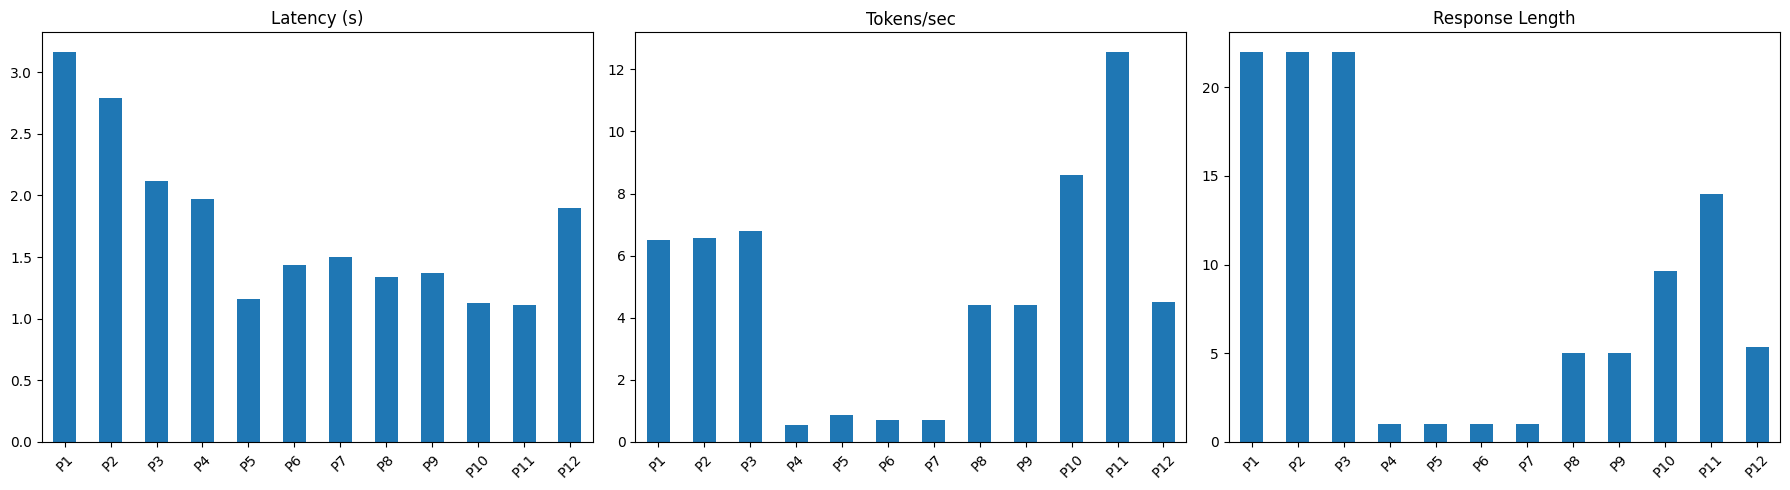

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
df['latency'].plot(kind='bar', ax=axs[0], title='Latency (s)')
df['tokens_per_sec'].plot(kind='bar', ax=axs[1], title='Tokens/sec')
df['response_length'].plot(kind='bar', ax=axs[2], title='Response Length')
for ax in axs:
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels([f"P{i+1}" for i in range(len(df))], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install rouge-score nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=48d7a817bb9079c6b4584ad74f23e5a3ad7e7b116184ce698164a78d0dc8e50e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
# Install required packages

from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# 40 example outputs and references (replace with your actual data)
outputs = [
    "The main themes in Hamlet are revenge, madness, and mortality.",
    "Macbeth is a tragic character driven by ambition and guilt.",
    "Jane Austen critiques society by highlighting class and gender issues.",
    "Wuthering Heights contains gothic elements like supernatural events.",
    "Dickens uses symbolism to represent social issues and character traits.",
    "A memorable character is complex, relatable, and undergoes development.",
    "Setting influences plot by shaping characters' actions and conflicts.",
    "Symbolism in literature adds deeper meaning to the narrative.",
    "Authors create suspense through pacing, foreshadowing, and uncertainty.",
    "The Declaration of Independence asserts the colonies' right to freedom.",
    "The Great Wall of China was built for defense against invasions.",
    "Shakespeare wrote approximately 37 plays and 154 sonnets.",
    "The Odyssey is an epic poem attributed to Homer.",
    "Moby Dick explores obsession and the human struggle against nature.",
    "The French Revolution began in 1789 and led to major social change.",
    "Romeo and Juliet is a tragedy about star-crossed lovers.",
    "George Orwell wrote Animal Farm as a political allegory.",
    "The Industrial Revolution transformed economies and societies.",
    "The Mona Lisa was painted by Leonardo da Vinci.",
    "Photosynthesis is the process by which plants make food.",
    "The capital of France is Paris.",
    "Water boils at 100 degrees Celsius.",
    "The Amazon is the largest rainforest in the world.",
    "Mount Everest is the highest mountain on Earth.",
    "The heart pumps blood throughout the body.",
    "Gravity is the force that attracts objects to Earth.",
    "The Pythagorean theorem relates the sides of a right triangle.",
    "The speed of light is about 299,792 kilometers per second.",
    "The human brain controls thoughts and actions.",
    "The Pacific Ocean is the largest ocean on Earth.",
    "The sun is a star at the center of our solar system.",
    "The Renaissance was a period of cultural rebirth in Europe.",
    "The Statue of Liberty is located in New York Harbor.",
    "The Wright brothers invented the first successful airplane.",
    "The periodic table organizes chemical elements.",
    "The internet connects computers worldwide.",
    "The Taj Mahal is a famous monument in India.",
    "The Nile is the longest river in the world.",
    "The moon orbits the Earth.",
    "The Great Fire of London occurred in 1666."
]

references = [
    "Revenge, madness, and mortality are the main themes in Hamlet.",
    "Macbeth is a tragic figure whose ambition leads to his downfall.",
    "Jane Austen critiques society by exposing class and gender inequalities.",
    "Wuthering Heights features gothic elements such as supernatural occurrences.",
    "Dickens uses symbolism to highlight social problems and character depth.",
    "A memorable character is well-developed, relatable, and dynamic.",
    "The setting affects the plot by influencing characters and events.",
    "Symbolism gives literature deeper layers of meaning.",
    "Suspense is created by authors through pacing and foreshadowing.",
    "The Declaration of Independence declared the colonies' independence.",
    "The Great Wall of China was constructed to protect against invasions.",
    "Shakespeare authored 37 plays and 154 sonnets.",
    "The Odyssey is an ancient Greek epic poem by Homer.",
    "Moby Dick examines obsession and man's struggle with nature.",
    "The French Revolution started in 1789 and changed French society.",
    "Romeo and Juliet tells the story of doomed young lovers.",
    "Animal Farm by George Orwell is a political allegory.",
    "The Industrial Revolution changed economies and societies worldwide.",
    "Leonardo da Vinci painted the Mona Lisa.",
    "Photosynthesis allows plants to convert sunlight into food.",
    "Paris is the capital city of France.",
    "Water's boiling point is 100 degrees Celsius.",
    "The Amazon rainforest is the largest in the world.",
    "Mount Everest is Earth's tallest mountain.",
    "The heart circulates blood throughout the body.",
    "Gravity pulls objects toward the Earth's surface.",
    "The Pythagorean theorem connects the sides of a right triangle.",
    "Light travels at about 299,792 kilometers per second.",
    "The brain is responsible for thoughts and actions.",
    "The Pacific Ocean is the world's largest ocean.",
    "The sun is the star at the center of the solar system.",
    "The Renaissance was a time of cultural renewal in Europe.",
    "The Statue of Liberty stands in New York Harbor.",
    "The Wright brothers built the first powered airplane.",
    "The periodic table classifies chemical elements.",
    "The internet links computers around the globe.",
    "The Taj Mahal is a renowned Indian monument.",
    "The Nile River is the world's longest river.",
    "The moon revolves around the Earth.",
    "The Great Fire of London happened in 1666."
]

# BLEU and ROUGE calculation
bleu_scores = []
rouge_l_scores = []

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for output, reference in zip(outputs, references):
    bleu = sentence_bleu([reference.split()], output.split())
    bleu_scores.append(bleu)
    rouge_l = scorer.score(reference, output)['rougeL'].fmeasure
    rouge_l_scores.append(rouge_l)

print("Average BLEU:", sum(bleu_scores) / len(bleu_scores))
print("Average ROUGE-L:", sum(rouge_l_scores) / len(rouge_l_scores))

Average BLEU: 0.18883338474734454
Average ROUGE-L: 0.6604663258997625


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_